In [8]:
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
import uproot as up
import pandas as pd 
import awkward as ak
from numba_stats import crystalball,crystalball_ex, norm, expon, voigt, truncexpon
from iminuit.cost import ExtendedBinnedNLL,ExtendedUnbinnedNLL, LeastSquares
from iminuit import Minuit
import os
import yaml

os.environ["HOMELUDO"]="/home/submit/mori25/"
os.environ["DPLUDO"]="/work/submit/mori25/Darkphotons_ludo/"


def load_analysis_config():
    try:
        with open(os.path.join(os.environ["DPLUDO"],"config/analysis_config.yml"), "r") as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
        return config

    except Exception as e: 
        raise e
    
config = load_analysis_config()

fYMC = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_MC.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()
fYData = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_data.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()

fYMC = fYMC[abs(fYMC["Mm_kin_eta"])<6]
fYData = fYData[abs(fYData["Mm_kin_eta"])<6]

fJpsiMC = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Jpsi_MC.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()
fJpsiData = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Jpsi_data.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays()


In [9]:
print(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_MC.root:RooTreeDataStore_dataWithSWeights_data_full"))

/data/submit/mori25/dark_photons_ludo/DimuonTrees/sPlot/files/data_withSWeight_Y_MC.root:RooTreeDataStore_dataWithSWeights_data_full


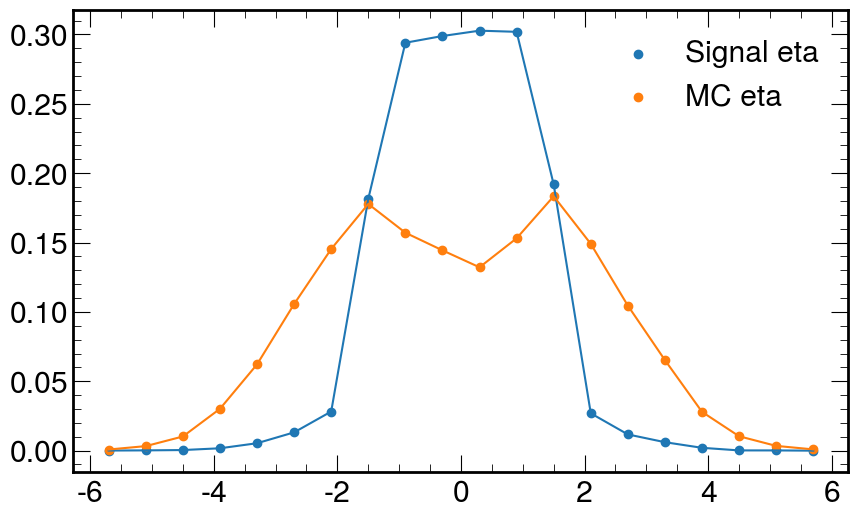

In [13]:
#Calculating eta corrections on the MC 
#MC correction based on eta 
nbins_correction = 20
histSEta,_ = np.histogram(fYData["Mm_kin_eta"],nbins_correction,weights=fYData["sigYield_sw"], range=(-6,6),  density=True) #range=(-8.38,6.9),-
histMCEta,edges = np.histogram(fYMC["Mm_kin_eta"],nbins_correction, weights = fYMC["sigYield_sw"], range=(-6,6), density=True)
weight_hist = np.where(histMCEta == 0, 0, histSEta/histMCEta)  

hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(0.5*(edges[:-1] + edges[1:]),histSEta, label = "Signal eta" )
ax.scatter(0.5*(edges[:-1] + edges[1:]),histMCEta, label = "MC eta")
ax.plot(0.5*(edges[:-1] + edges[1:]),histSEta,)
ax.plot(0.5*(edges[:-1] + edges[1:]),histMCEta,)
# ax.scatter(0.5*(edges[:-1] + edges[1:]),weight_hist,)
ax.legend()

corrections = weight_hist[np.digitize(fYMC["Mm_kin_eta"], edges) - 1]
corrections = corrections/np.sum(corrections)

In [22]:
"""
A first study of the efficiency of the BDT on the Y peak. Here look at the BDT trained on Y

"""

#These are the  s/sqrt(b) - optimized cuts. s and b discerned by simple mass cut 
cutJDataId =  0.45
cutJDataBdt = 0.652

print(f"Study efficiency of cuts on Jpsi peak \nID cut: {cutJDataId}\nBDT cut: {cutJDataBdt}")

#The BDT results before the cut
scoreYData = fYData["forest_standard_Y_mva"]
scoreYMC = fYMC["forest_standard_Y_mva"]

#The total signal yields as for the sPlot weights before cuts
YdataTotalYield = np.sum(fYData["sigYield_sw"])
YMCTotalYield = np.sum(fYMC["sigYield_sw"])
print("Total data signal yield: ", YdataTotalYield)
print("Total MC signal yield: ", YMCTotalYield, "\n\n")

#compute corrected weights
corr_weights = 0.5*(corrections*YMCTotalYield + fYMC["sigYield_sw"])

nbins = 100
histYB,_ = np.histogram(scoreYData,nbins,(0,1),False,fYData["bkgYield_sw"])
histYS,xe = np.histogram(scoreYData,nbins,(0,1),False,fYData["sigYield_sw"])
histYMC,_ = np.histogram(scoreYMC,nbins,(0,1),False, fYMC["sigYield_sw"])
histYMC_corrected,_ = np.histogram(scoreYMC,nbins,(0,1),False,corr_weights)

dx = xe[1]-xe[0]
x = 0.5*(xe[:-1]+xe[1:])

#The event cuts on the ID
dataCutOnIDJ = (fYData["Muon_softMva1"] > cutJDataId) & (fYData["Muon_softMva2"]> cutJDataId)  
MCCutOnIDJ = (fYMC["Muon_softMva1"] > cutJDataId) & (fYMC["Muon_softMva2"] > cutJDataId)     

print("Efficiency data ID cut: ", np.sum(fYData["sigYield_sw"][dataCutOnIDJ])/YdataTotalYield)
print("Efficiency MC ID cut: ", np.sum(fYMC["sigYield_sw"][MCCutOnIDJ])/YMCTotalYield, "\n\n")
print("Efficiency corrected MC ID cut: ", np.sum(corr_weights[MCCutOnIDJ])/YMCTotalYield, "\n\n")

histYB_IDcut,_ = np.histogram(scoreYData[dataCutOnIDJ],nbins,(0,1),False,fYData["bkgYield_sw"][dataCutOnIDJ])
histYS_IDcut,_ = np.histogram(scoreYData[dataCutOnIDJ],nbins,(0,1),False,fYData["sigYield_sw"][dataCutOnIDJ])
histYMC_IDcut,_ = np.histogram(scoreYMC[MCCutOnIDJ],nbins,(0,1),False,fYMC["sigYield_sw"][MCCutOnIDJ])
histYMC_corr_IDcut,_ = np.histogram(scoreYMC[MCCutOnIDJ],nbins,(0,1),False,corr_weights[MCCutOnIDJ])

print("check yields after ID cut:", np.sum(histYS_IDcut), np.sum(histYMC_IDcut), np.sum(histYMC_corr_IDcut), "\n")

YdataYield = np.sum(histYS_IDcut*(x>cutJDataBdt) )
YMCYield = np.sum(histYMC_IDcut*(x>cutJDataBdt) )
YMC_corr_Yield = np.sum(histYMC_corr_IDcut*(x>cutJDataBdt) )

print("dataYield " , YdataYield)
print("MCYield " , YMCYield, "\n\n")
print("MC corr Yield " , YMC_corr_Yield, "\n\n")

effYData =  YdataYield/YdataTotalYield
effYMC = YMCYield/YMCTotalYield
effYMC_corr = YMC_corr_Yield/YMCTotalYield

print("BDT efficiency on Y peak: \n On data: ",effYData, "\n On MC: ", effYMC, "\n On corrected MC: ", effYMC_corr)
print("Efficiency difference: " , (effYMC_corr - effYData))



Study efficiency of cuts on Jpsi peak 
ID cut: 0.45
BDT cut: 0.652
Total data signal yield:  51716.07968330263
Total MC signal yield:  21127.211737890357 


Efficiency data ID cut:  0.9438795234542361
Efficiency MC ID cut:  0.9087790230436085 


Efficiency corrected MC ID cut:  0.9047552646783862 


check yields after ID cut: 48813.74864639732 19199.96684279539 19114.956047831318 

dataYield  39442.473743764334
MCYield  10909.825919805742 


MC corr Yield  12390.352149348819 


BDT efficiency on Y peak: 
 On data:  0.7626733113820878 
 On MC:  0.5163873991114332 
 On corrected MC:  0.5864641441126603
Efficiency difference:  -0.17620916726942748


Text(0, 1, 'Normalized frequency')

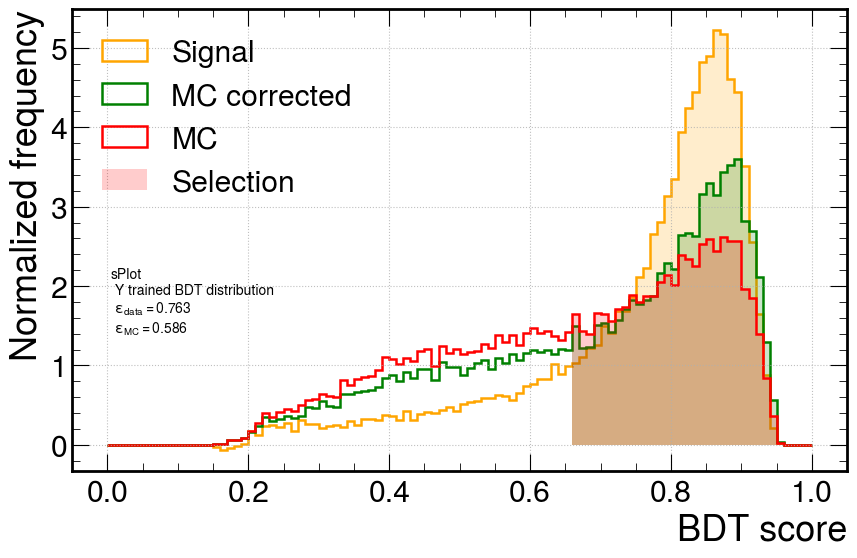

In [26]:
x = 0.5*(xe[:-1]+xe[1:])
# fine_x = np.linspace(x[0],x[-1],1000)
dx = np.diff(xe)[0]

bin_cut=np.digitize(cutJDataBdt, xe)

hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
# ax.hist(scoreYData, nbins, (0,1),  False, weights = fYData["bkgYield_sw"]/YdataTotalYield*nbins, label="Background", color = "blue", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYData, nbins, (0,1),  False, weights = fYData["sigYield_sw"]/YdataTotalYield*nbins, label="Signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYData, nbins, (0,1),  False, weights = fYData["sigYield_sw"]*(scoreYData>xe[bin_cut])/YdataTotalYield*nbins, color = "orange", zorder=0, histtype='bar', linewidth = 1.8, alpha = .2)

ax.hist(scoreYMC, nbins, (0,1),  False, weights =  0.5*(corrections+fYMC["sigYield_sw"]/YMCTotalYield)*nbins, label="MC corrected", color = "green", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYMC, nbins, (0,1),  False, weights =  0.5*(corrections+fYMC["sigYield_sw"]/YMCTotalYield)*(scoreYMC>xe[bin_cut])*nbins,  color = "green", zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)

ax.hist(scoreYMC, nbins, (0,1),  False, weights =  fYMC["sigYield_sw"]/YMCTotalYield*nbins, label="MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYMC, nbins, (0,1),  False, weights =  fYMC["sigYield_sw"]*(scoreYMC>xe[bin_cut])/YMCTotalYield*nbins,  color = "red", label ='Selection', zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)
ax.text(0.05,0.3, f"sPlot\n Y trained BDT distribution \n $\epsilon_{{data}} = ${round(effYData,3)} \n $\epsilon_{{MC}} = ${round(effYMC_corr,3)}", fontsize = 10,  transform=ax.transAxes)
ax.grid()
ax.legend()    
ax.set_xlabel("BDT score")
ax.set_ylabel("Normalized frequency")

In [ ]:
"""
A first study of the efficiency of the BDT on the Jpsi peak. Here look at the BDT trained on Y

"""

#These are the  s/sqrt(b) - optimized cuts. s and b discerned by simple mass cut 
cutJDataId =  0.45
cutJDataBdt = 0.652

print(f"Study efficiency of cuts on Jpsi peak \nID cut: {cutJDataId}\nBDT cut: {cutJDataBdt}")

#The BDT results before the cut
scoreYData = fYData["forest_standard_Y_mva"]
scoreYMC = fYMC["forest_standard_Y_mva"]

#The total signal yields as for the sPlot weights before cuts
YdataTotalYield = np.sum(fYData["sigYield_sw"])
YMCTotalYield = np.sum(fYMC["sigYield_sw"])
print("Total data signal yield: ", YdataTotalYield)
print("Total MC signal yield: ", YMCTotalYield, "\n\n")

#compute corrected weights
corr_weights = 0.5*(corrections*YMCTotalYield + fYMC["sigYield_sw"])

nbins = 100
histYB,_ = np.histogram(scoreYData,nbins,(0,1),False,fYData["bkgYield_sw"])
histYS,xe = np.histogram(scoreYData,nbins,(0,1),False,fYData["sigYield_sw"])
histYMC,_ = np.histogram(scoreYMC,nbins,(0,1),False, fYMC["sigYield_sw"])
histYMC_corrected,_ = np.histogram(scoreYMC,nbins,(0,1),False,corr_weights)

dx = xe[1]-xe[0]
x = 0.5*(xe[:-1]+xe[1:])

#The event cuts on the ID
dataCutOnIDJ = (fYData["Muon_softMva1"] > cutJDataId) & (fYData["Muon_softMva2"]> cutJDataId)  
MCCutOnIDJ = (fYMC["Muon_softMva1"] > cutJDataId) & (fYMC["Muon_softMva2"] > cutJDataId)     

print("Efficiency data ID cut: ", np.sum(fYData["sigYield_sw"][dataCutOnIDJ])/YdataTotalYield)
print("Efficiency MC ID cut: ", np.sum(fYMC["sigYield_sw"][MCCutOnIDJ])/YMCTotalYield, "\n\n")
print("Efficiency corrected MC ID cut: ", np.sum(corr_weights[MCCutOnIDJ])/YMCTotalYield, "\n\n")

histYB_IDcut,_ = np.histogram(scoreYData[dataCutOnIDJ],nbins,(0,1),False,fYData["bkgYield_sw"][dataCutOnIDJ])
histYS_IDcut,_ = np.histogram(scoreYData[dataCutOnIDJ],nbins,(0,1),False,fYData["sigYield_sw"][dataCutOnIDJ])
histYMC_IDcut,_ = np.histogram(scoreYMC[MCCutOnIDJ],nbins,(0,1),False,fYMC["sigYield_sw"][MCCutOnIDJ])
histYMC_corr_IDcut,_ = np.histogram(scoreYMC[MCCutOnIDJ],nbins,(0,1),False,corr_weights[MCCutOnIDJ])

print("check yields after ID cut:", np.sum(histYS_IDcut), np.sum(histYMC_IDcut), np.sum(histYMC_corr_IDcut), "\n")

YdataYield = np.sum(histYS_IDcut*(x>cutJDataBdt) )
YMCYield = np.sum(histYMC_IDcut*(x>cutJDataBdt) )
YMC_corr_Yield = np.sum(histYMC_corr_IDcut*(x>cutJDataBdt) )

print("dataYield " , YdataYield)
print("MCYield " , YMCYield, "\n\n")
print("MC corr Yield " , YMC_corr_Yield, "\n\n")

effYData =  YdataYield/YdataTotalYield
effYMC = YMCYield/YMCTotalYield
effYMC_corr = YMC_corr_Yield/YMCTotalYield

print("BDT efficiency on Y peak: \n On data: ",effYData, "\n On MC: ", effYMC, "\n On corrected MC: ", effYMC_corr)
print("Efficiency difference: " , (effYMC_corr - effYData))



In [ ]:
x = 0.5*(xe[:-1]+xe[1:])
# fine_x = np.linspace(x[0],x[-1],1000)
dx = np.diff(xe)[0]

bin_cut=np.digitize(cutJDataBdt, xe)

hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
# ax.hist(scoreYData, nbins, (0,1),  False, weights = fYData["bkgYield_sw"]/YdataTotalYield*nbins, label="Background", color = "blue", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYData, nbins, (0,1),  False, weights = fYData["sigYield_sw"]/YdataTotalYield*nbins, label="Signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYData, nbins, (0,1),  False, weights = fYData["sigYield_sw"]*(scoreYData>xe[bin_cut])/YdataTotalYield*nbins, color = "orange", zorder=0, histtype='bar', linewidth = 1.8, alpha = .2)

ax.hist(scoreYMC, nbins, (0,1),  False, weights =  0.5*(corrections+fYMC["sigYield_sw"]/YMCTotalYield)*nbins, label="MC corrected", color = "green", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYMC, nbins, (0,1),  False, weights =  0.5*(corrections+fYMC["sigYield_sw"]/YMCTotalYield)*(scoreYMC>xe[bin_cut])*nbins,  color = "green", zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)

ax.hist(scoreYMC, nbins, (0,1),  False, weights =  fYMC["sigYield_sw"]/YMCTotalYield*nbins, label="MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYMC, nbins, (0,1),  False, weights =  fYMC["sigYield_sw"]*(scoreYMC>xe[bin_cut])/YMCTotalYield*nbins,  color = "red", label ='Selection', zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)
ax.text(0.05,0.3, f"sPlot\n Y trained BDT distribution \n $\epsilon_{{data}} = ${round(effYData,3)} \n $\epsilon_{{MC}} = ${round(effYMC_corr,3)}", fontsize = 10,  transform=ax.transAxes)
ax.grid()
ax.legend()    
ax.set_xlabel("BDT score")
ax.set_ylabel("Normalized frequency")

173.83864037581975 0.021087433039086802 1418.944322481622
174498.86479597227 793097


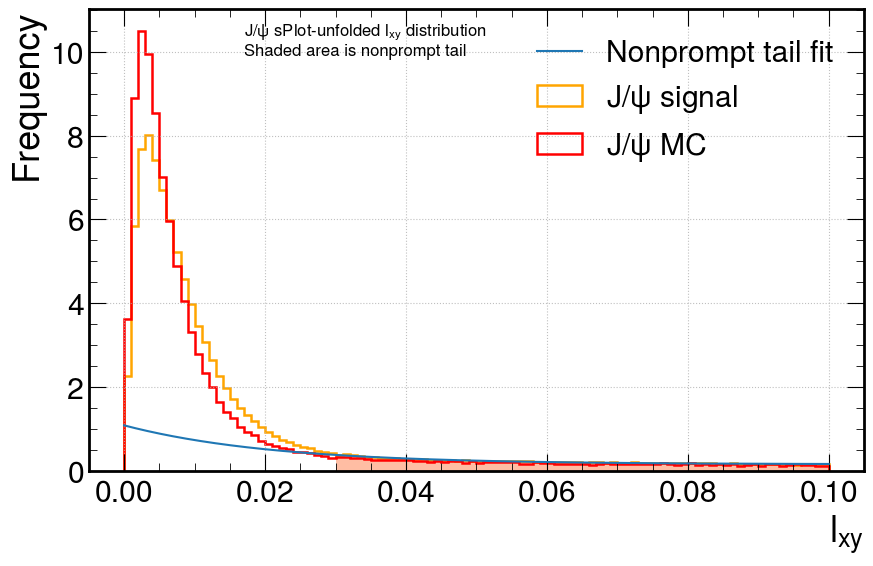

In [ ]:
"""
Look at lxy distribution; fit nonprompt tail with exp + const and extrapolate corrections to prompt part
"""
lxy_range=(0,0.1)
mask_range = 0.03, lxy_range[1]
dx = (lxy_range[1]-lxy_range[0])/nbins

def nonPrompt_tail(x,N,b,c):
   return  N*expon.pdf(x,0.0,b) + c

##Failed attempt with ExtendedUNLL
# costMethod = ExtendedUnbinnedNLL
# cf_data = costMethod(ak.to_numpy(fJpsiData["Mm_kin_lxy"]),nonPrompt_tail)
# cf_data.mask = (fJpsiData["Mm_kin_lxy"] > mask_range[0]) & (fJpsiData["Mm_kin_lxy"] < mask_range[1])

costMethod = LeastSquares
n,xe = np.histogram(ak.to_numpy(fJpsiData["Mm_kin_lxy"]), nbins, lxy_range, weights = ak.to_numpy(fJpsiData["sigYield_sw"]))
x = 0.5*(xe[1:] + xe[:-1])
mask = (x > mask_range[0]) & (x < mask_range[1])
cf_data = costMethod(x[mask], n[mask], n[mask]**0.5, nonPrompt_tail)

ivData = len(fJpsiData["Mm_kin_lxy"]),  0.4, 1
mData = Minuit(cf_data,*ivData)
mData.limits = [(0,len(fJpsiData["Mm_kin_lxy"])), (0,1),(0,len(fJpsiData["Mm_kin_lxy"]))]
mData.migrad()
mData.hesse() 
print(*mData.values)

fig, ax = plt.subplots(figsize=(10,6))

x = np.linspace(*lxy_range, 1000)
ax.plot(x,nonPrompt_tail(x,*mData.values)/JpsidataTotalYield*nbins, label = "Nonprompt tail fit")

ax.hist(fJpsiData["Mm_kin_lxy"], nbins, lxy_range,  False, weights = fJpsiData["sigYield_sw"]/JpsidataTotalYield*nbins, label="$J/\psi$ signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(fJpsiData["Mm_kin_lxy"], nbins, lxy_range,  False, weights = fJpsiData["sigYield_sw"]*(fJpsiData["Mm_kin_lxy"]>mask_range[0])/JpsidataTotalYield*nbins, color = "orange", zorder=0, histtype='bar', linewidth = 1.8, alpha = .2)
ax.hist(fJpsiMC["Mm_kin_lxy"], nbins, lxy_range,  False, weights =  fJpsiMC["sigYield_sw"]/JpsiMCTotalYield*nbins, label="$J/\psi$ MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(fJpsiMC["Mm_kin_lxy"], nbins, lxy_range,  False, weights =  fJpsiMC["sigYield_sw"]*(fJpsiMC["Mm_kin_lxy"]>mask_range[0])/JpsiMCTotalYield*nbins,  color = "red", zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)
# ax.hist(fYData["Mm_kin_lxy"], nbins, lxy_range,  True, weights = fYData["sigYield_sw"], label="Y signal", color = "blue", zorder=0, histtype='step', linewidth = 1.8)

ax.text(0.2,0.9, f"J/$\psi$ sPlot-unfolded $l_{{xy}}$ distribution \nShaded area is nonprompt tail", fontsize = 12, transform=ax.transAxes)

ax.grid()
ax.legend()    
ax.set_xlabel("$l_{xy}$")
# ax.set_ylim(0,20000)
ax.set_ylabel("Frequency")

import scipy
Nonprompt_in_prompt,_ = scipy.integrate.quad(lambda x: nonPrompt_tail(x,*mData.values), 0, mask_range[0])
print(Nonprompt_in_prompt*1000,np.sum(fJpsiData["Mm_kin_lxy"] < mask_range[0]))

# histS,edges = np.histogram(sigJ[(sigJ["Mm_mass"]>mjpsi-window) & (sigJ["Mm_mass"]<mjpsi+window)]["Mm_kin_eta"],20, range=(-2.3,2.3),density=True)
# histMC,_ = np.histogram(dataMCJ["Mm_kin_eta"],20, range=(-2.3,2.3),density=True)
# weight_hist = histS/histMC
# corrections = weight_hist[np.digitize(dataMCJ["Mm_kin_eta"], edges) - 1]
# pred_MCJ = dataMCJ["vtx_BDT_forest"]

Now look into the efficiency of Jpsi, this time applying a cut that excludes events with large lxy. 

In [ ]:
cutJlxy = mask_range[0]

print(f"Study efficiency of cuts on Jpsi peak with cut lxy<cutJlxy \nID cut : {cutJDataId}\nBDT cut: {cutJDataBdt}\nAdditional cut on $l_{{xy}}$: {cutJlxy}")

#The total signal yields as for the sPlot weights before all cuts. Only to look at efficiency of lxy cut
JpsidataTotalYield = np.sum(fJpsiData["sigYield_sw"])
JpsiMCTotalYield = np.sum(fJpsiMC["sigYield_sw"])

dataCutOnLxy = fJpsiData["Mm_kin_lxy"] < cutJlxy
MCCutOnLxy = fJpsiMC["Mm_kin_lxy"] < cutJlxy

"""
From now in this block on look at prompt Jpsis. THat is after cut on lxy to exclude some nonprompt events 

"""
fJpsiData_lxy = fJpsiData[dataCutOnLxy]
fJpsiMC_lxy = fJpsiMC[MCCutOnLxy]

#The total signal yields as for the sPlot weights before cuts but after selection on lxy
JpsidataTotalYield_lxy = np.sum(fJpsiData_lxy["sigYield_sw"])
JpsiMCTotalYield_lxy = np.sum(fJpsiMC_lxy["sigYield_sw"])

print("Efficiency data l_{xy} cut: ",JpsidataTotalYield_lxy/JpsidataTotalYield)
print("Efficiency MC l_{xy} cut: ", JpsiMCTotalYield_lxy/JpsiMCTotalYield, "\n\n")

print("Total data signal yield (after lxy cut): ", JpsidataTotalYield_lxy)
print("Total MC signal yield (after lxy cut): ", JpsiMCTotalYield_lxy, "\n\n")


#The BDT results before the cuts on ID and vertex BDT
scoreJpsiData_lxy = fJpsiData_lxy["vtx_BDT_Y_forest"]
scoreJpsiMC_lxy = fJpsiMC_lxy["vtx_BDT_Y_forest"]

# Histograms before cuts. Here just for coherence, are currently not used anywhere
nbins = 100
histJpsiB_lxy,_ = np.histogram(scoreJpsiData_lxy,nbins,(0,1),False,fJpsiData_lxy["bkgYield_sw"])
histJpsiS_lxy,xe = np.histogram(scoreJpsiData_lxy,nbins,(0,1),False,fJpsiData_lxy["sigYield_sw"])
histJpsiMC_lxy,_ = np.histogram(scoreJpsiMC_lxy,nbins,(0,1),False,fJpsiMC_lxy["sigYield_sw"])
dx = xe[1]-xe[0]
x = 0.5*(xe[:-1]+xe[1:])


#The event cuts on the ID
dataCutOnIDJ_lxy = (fJpsiData_lxy["Muon_softMva1"] > cutJDataId) & (fJpsiData_lxy["Muon_softMva2"]> cutJDataId)  
MCCutOnIDJ_lxy = (fJpsiMC_lxy["Muon_softMva1"] > cutJDataId) & (fJpsiMC_lxy["Muon_softMva2"] > cutJDataId)     

print("Efficiency data ID cut: ", np.sum(fJpsiData_lxy["sigYield_sw"][dataCutOnIDJ_lxy])/JpsidataTotalYield_lxy)
print("Efficiency MC ID cut: ", np.sum(fJpsiMC_lxy["sigYield_sw"][MCCutOnIDJ_lxy])/JpsiMCTotalYield_lxy, "\n\n")


histJpsiB_IDcut_lxy,_ = np.histogram(scoreJpsiData_lxy[dataCutOnIDJ_lxy],nbins,(0,1),False,fJpsiData_lxy["bkgYield_sw"][dataCutOnIDJ_lxy])
histJpsiS_IDcut_lxy,_ = np.histogram(scoreJpsiData_lxy[dataCutOnIDJ_lxy],nbins,(0,1),False,fJpsiData["sigYield_sw"][dataCutOnIDJ_lxy])
histJpsiMC_IDcut_lxy,_ = np.histogram(scoreJpsiMC_lxy[MCCutOnIDJ_lxy],nbins,(0,1),False,fJpsiMC_lxy["sigYield_sw"][MCCutOnIDJ_lxy])

print("check yields after ID cut:", np.sum(histJpsiS_IDcut_lxy), np.sum(histJpsiMC_IDcut_lxy), "\n")

JpsidataYield_lxy = np.sum(histJpsiS_IDcut_lxy*(x>cutJDataBdt) )
JpsiMCYield_lxy = np.sum( histJpsiMC_IDcut_lxy*(x>cutJDataBdt) )

print("dataYield_lxy " , JpsidataYield_lxy)
print("MCYield_lxy " , JpsiMCYield_lxy, "\n\n")

effJData_lxy =  JpsidataYield_lxy/JpsidataTotalYield_lxy
effJMC_lxy = JpsiMCYield_lxy/JpsiMCTotalYield_lxy

print("BDT efficiency on Jpsi peak: \n On data: ",effJData_lxy, "\n On MC: ", effJMC_lxy)
print("Efficiency difference: " , (effJMC_lxy - effJData_lxy))

Study efficiency of cuts on Jpsi peak with cut lxy<cutJlxy 
ID cut : 0.402
BDT cut: 0.637
Additional cut on $l_{xy}$: 0.03
Efficiency data l_{xy} cut:  0.842358570129575
Efficiency MC l_{xy} cut:  0.8640588790108565 


Total data signal yield (after lxy cut):  747567.9162356025
Total MC signal yield (after lxy cut):  107435.81539903085 


Efficiency data ID cut:  0.9409696628700377
Efficiency MC ID cut:  0.9244182415216834 


check yields after ID cut: 668860.2719552048 99315.62754761949 

dataYield_lxy  335043.9497537904
MCYield_lxy  72266.70576855983 


BDT efficiency on Jpsi peak: 
 On data:  0.44817861023372013 
 On MC:  0.672650042261528
Efficiency difference:  0.2244714320278079


Text(0, 1, 'Normalized frequency')

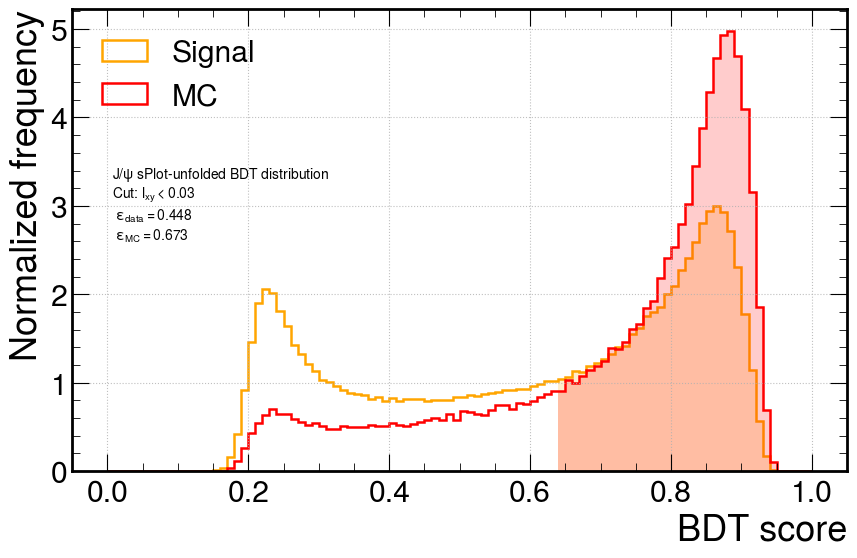

In [ ]:
x = 0.5*(xe[:-1]+xe[1:])
# fine_x = np.linspace(x[0],x[-1],1000)
dx = np.diff(xe)[0]

bin_cut = np.digitize(cutJDataBdt, xe)

hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
# ax.hist(xe[:-1], nbins, (0,1),   True, weights =  histJpsiB, label="Background", color = "blue", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiData_lxy, nbins, (0,1),  False, weights = fJpsiData_lxy["sigYield_sw"]/JpsidataTotalYield_lxy*nbins, label="Signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiData_lxy, nbins, (0,1),  False, weights = fJpsiData_lxy["sigYield_sw"]*(scoreJpsiData_lxy>xe[bin_cut])/JpsidataTotalYield_lxy*nbins, color = "orange", zorder=0, histtype='bar', linewidth = 1.8, alpha = .2)
ax.hist(scoreJpsiMC_lxy, nbins, (0,1),  False, weights =  fJpsiMC_lxy["sigYield_sw"]/JpsiMCTotalYield_lxy*nbins, label="MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiMC_lxy, nbins, (0,1),  False, weights =  fJpsiMC_lxy["sigYield_sw"]*(scoreJpsiMC_lxy>xe[bin_cut])/JpsiMCTotalYield_lxy*nbins,  color = "red", zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)
ax.text(0.051,0.5, f"J/$\psi$ sPlot-unfolded BDT distribution\nCut: $l_{{xy}}<{cutJlxy}$ \n $\epsilon_{{data}} = ${round(effJData_lxy,3)} \n $\epsilon_{{MC}} = ${round(effJMC_lxy,3)}", fontsize = 10,  transform=ax.transAxes)

ax.grid()
ax.legend()    
ax.set_xlabel("BDT score")
ax.set_ylabel("Normalized frequency")

Look into efficiency of extrapolated prompt events

174.49886479597228 139902.03153331022
BDT efficiency on Jpsi peak: 
 On data:  0.5228973731422608 
 On MC:  0.672650042261528
Efficiency difference:  0.1497526691192672


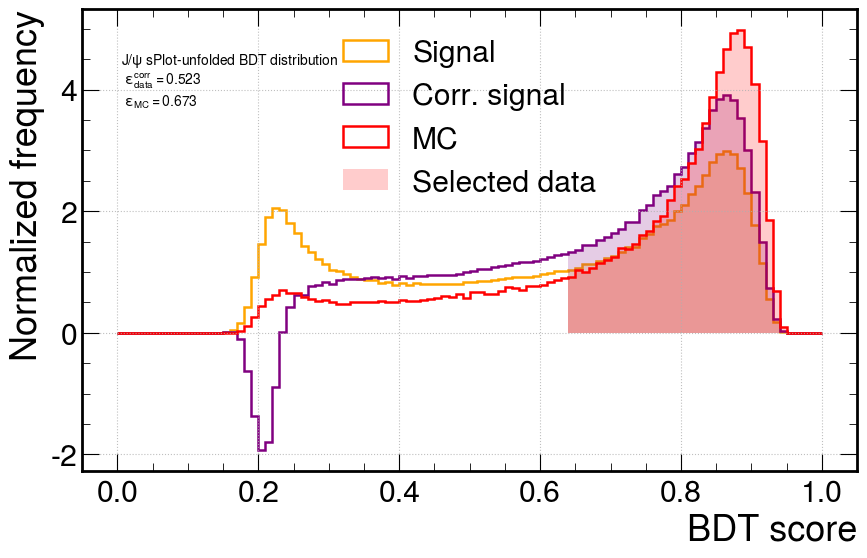

Text(0, 1, 'Frequency')

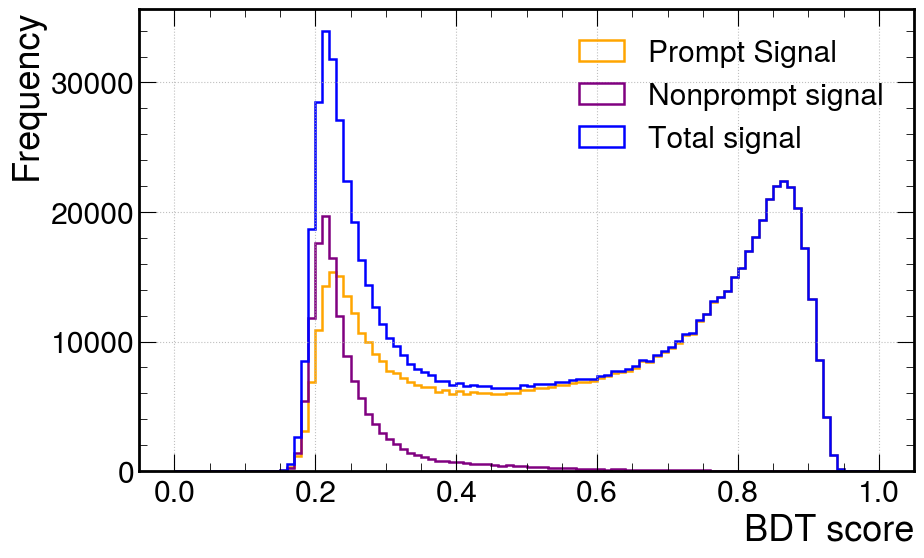

In [ ]:
x = 0.5*(xe[:-1]+xe[1:])
# fine_x = np.linspace(x[0],x[-1],1000)
dx = np.diff(xe)[0]

bin_cut = np.digitize(cutJDataBdt, xe)

#Jpsi peak in nonprompt region
fJpsiData_lxy_nonprompt = fJpsiData[~dataCutOnLxy & (fJpsiData["Mm_kin_lxy"]<0.1)]

histJpsiS_nonprompt, _ = np.histogram(fJpsiData_lxy_nonprompt["vtx_BDT_Y_forest"],nbins,(0,1),False,fJpsiData_lxy_nonprompt["sigYield_sw"])
histJpsiS_corrected = histJpsiS_lxy - 1000*Nonprompt_in_prompt/np.sum(histJpsiS_nonprompt)*histJpsiS_nonprompt
print(Nonprompt_in_prompt,np.sum(histJpsiS_nonprompt))

corrYield = np.sum(histJpsiS_corrected*(x>cutJDataBdt))
effJData_lxy =  corrYield/JpsidataTotalYield_lxy
effJMC_lxy = JpsiMCYield_lxy/JpsiMCTotalYield_lxy

print("BDT efficiency on Jpsi peak: \n On data: ",effJData_lxy, "\n On MC: ", effJMC_lxy)
print("Efficiency difference: " , (effJMC_lxy - effJData_lxy))


hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(scoreJpsiData_lxy, nbins, (0,1),  False, weights = fJpsiData_lxy["sigYield_sw"]/JpsidataTotalYield_lxy*nbins, label="Signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiData_lxy, nbins, (0,1),  False, weights = fJpsiData_lxy["sigYield_sw"]*(scoreJpsiData_lxy>xe[bin_cut])/JpsidataTotalYield_lxy*nbins, color = "orange", zorder=0, histtype='bar', linewidth = 1.8, alpha = .2)

ax.hist(xe[:-1], nbins, (0,1), False, weights = histJpsiS_corrected/np.sum(histJpsiS_corrected)*nbins, label="Corr. signal", color = "purple", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(xe[:-1], nbins, (0,1), False, weights = histJpsiS_corrected*(xe[:-1]>=xe[bin_cut])/np.sum(histJpsiS_corrected)*nbins, color = "purple", zorder=0, histtype='bar', linewidth = 1.8,alpha=.2)

ax.hist(scoreJpsiMC_lxy, nbins, (0,1),  False, weights =  fJpsiMC_lxy["sigYield_sw"]/JpsiMCTotalYield_lxy*nbins, label="MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreJpsiMC_lxy, nbins, (0,1),  False, weights =  fJpsiMC_lxy["sigYield_sw"]*(scoreJpsiMC_lxy>xe[bin_cut])/JpsiMCTotalYield_lxy*nbins,  label="Selected data", color = "red", zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)

ax.text(0.05,0.79, f"J/$\psi$ sPlot-unfolded BDT distribution \n $\epsilon_{{data}}^{{corr}} = ${round(effJData_lxy,3)} \n $\epsilon_{{MC}} = ${round(effJMC_lxy,3)}", fontsize = 10,transform=ax.transAxes)

ax.grid()
ax.legend()    
ax.set_xlabel("BDT score")
ax.set_ylabel("Normalized frequency")
plt.show()





hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(scoreJpsiData_lxy, nbins, (0,1),  False, weights = fJpsiData_lxy["sigYield_sw"], label="Prompt Signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(fJpsiData_lxy_nonprompt["vtx_BDT_Y_forest"],nbins,(0,1),False,weights = fJpsiData_lxy_nonprompt["sigYield_sw"], label ="Nonprompt signal", color = "purple", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(fJpsiData["vtx_BDT_Y_forest"],nbins,(0,1),False,weights = fJpsiData["sigYield_sw"], label ="Total signal", color = "Blue", zorder=0, histtype='step', linewidth = 1.8)

# ax.hist(scoreJpsiMC_lxy, nbins, (0,1),  False, weights =  fJpsiMC_lxy["sigYield_sw"]/JpsiMCTotalYield_lxy*nbins, label="MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
# ax.hist(scoreJpsiMC_lxy, nbins, (0,1),  False, weights =  fJpsiMC_lxy["sigYield_sw"]*(scoreJpsiMC_lxy>xe[bin_cut])/JpsiMCTotalYield_lxy*nbins,  color = "red", zorder=0, histtype='bar', linewidth = 1.8 , alpha=.2)

# ax.text(0.05,0.79, f"J/$\psi$ sPlot-unfolded BDT distribution \n $\epsilon_{{data}}^{{corr}} = ${round(effJData_lxy,3)} \n $\epsilon_{{MC}} = ${round(effJMC_lxy,3)}", fontsize = 10, transform=ax.transAxes)

ax.grid()
ax.legend()    
ax.set_xlabel("BDT score")
ax.set_ylabel("Frequency")

Now do the same for the Y peak 

In [ ]:
#These are the  s/sqrt(b) - optimized cuts. s and b discerned by simple mass cut 
cutYDataId =0.396
cutYDataBdt = 0.5#0.797

print(f"Study efficiency of cuts on Upsilon peak \nID cut: {cutYDataId}\nBDT cut: {cutYDataBdt}")

#Select only signal around Y1. from now on only use fY1!!!  
Y1_cut =   (fYData["Mm_mass"] > 9.2) & (fYData["Mm_mass"] < 9.7) #fYData["Mm_mass"] >0 # 
fY1Data = fYData[Y1_cut]

#The BDT results before the cut
scoreY1Data = fY1Data["vtx_BDT_forest"]
scoreYMC = fYMC["vtx_BDT_forest"]

nbins = 100
histY1B,_ = np.histogram(scoreY1Data,nbins,(0,1),False,fY1Data["bkgYield_sw"])
histY1S,xe = np.histogram(scoreY1Data,nbins,(0,1),False,fY1Data["sigYield_sw"])
histYMC,_ = np.histogram(scoreYMC,nbins,(0,1),False,fYMC["sigYield_sw"])

dx = xe[1]-xe[0]
x = 0.5*(xe[:-1]+xe[1:])

#The total signal yields as for the sPlot weights before cuts
dataTotalYield = np.sum(fY1Data["sigYield_sw"])
MCTotalYield = np.sum(fYMC["sigYield_sw"])
bkgTotalYield = np.sum(fY1Data["bkgYield_sw"])

print("Total data signal yield: ", dataTotalYield)
print("Total MC signal yield: ", MCTotalYield)
print("Total data bkg yield: ", bkgTotalYield, "\n\n")

#The event cuts on the ID
dataCutOnIDY = (fY1Data["Muon_softMva1"] > cutYDataId) & (fY1Data["Muon_softMva2"]> cutYDataId)  
MCCutOnIDY = (fYMC["Muon_softMva1"] > cutYDataId) & (fYMC["Muon_softMva2"] > cutYDataId)     

print("Efficiency data ID cut: ", np.sum(fY1Data["sigYield_sw"][dataCutOnIDY])/dataTotalYield) 
print("Efficiency MC ID cut: ", np.sum(fYMC["sigYield_sw"][MCCutOnIDY])/MCTotalYield, "\n\n")


histY1B_IDcut,_ = np.histogram(scoreY1Data[dataCutOnIDY],nbins,(0,1),False,fY1Data["bkgYield_sw"][dataCutOnIDY])
histY1S_IDcut,_ = np.histogram(scoreY1Data[dataCutOnIDY],nbins,(0,1),False,fY1Data["sigYield_sw"][dataCutOnIDY])
histYMC_IDcut,_ = np.histogram(scoreYMC[MCCutOnIDY],nbins,(0,1),False,fYMC["sigYield_sw"][MCCutOnIDY])
histYMC_IDcut_corr, _  = np.histogram(scoreYMC[MCCutOnIDY],nbins,(0,1),False, 0.5*((fYMC["sigYield_sw"] ) + corrections*MCTotalYield)[MCCutOnIDY])


print("check yields after ID cut:", np.sum(histY1S_IDcut), np.sum(histYMC_IDcut), "\n")

dataY1ield = np.sum( histY1S_IDcut*(x>cutYDataBdt) )
MCYield = np.sum( histYMC_IDcut*(x>cutYDataBdt) )
MCYield_corr = np.sum( histYMC_IDcut_corr*(x>cutYDataBdt) )

print("Yields after BDT ID cuts:")
print("dataYield " , dataY1ield)
print("MCYield " , MCYield, "\n\n")

effData =  dataY1ield/dataTotalYield
effMC = MCYield/MCTotalYield
effMC_corr = MCYield_corr/MCTotalYield

print("BDT efficiency on Y peak: \n On data: ",effData, "\n On MC: ", effMC, "\n On corrected MC: ", effMC_corr)
print("Relative efficiency difference: " , (effMC_corr - effData))

Study efficiency of cuts on Upsilon peak 
ID cut: 0.396
BDT cut: 0.5
Total data signal yield:  46657.26847530816
Total MC signal yield:  42594.49953366016
Total data bkg yield:  -7185.079518269618 


Efficiency data ID cut:  0.9562525019974794
Efficiency MC ID cut:  0.933470070082752 


check yields after ID cut: 44616.129715881245 39760.69046482569 

Yields after BDT ID cuts:
dataYield  37964.30717076034
MCYield  37064.19258351026 


BDT efficiency on Y peak: 
 On data:  0.8136847357631257 
 On MC:  0.8701638237167315 
 On corrected MC:  0.8725783185357885
Relative efficiency difference:  0.05889358277266277


Text(0, 1, 'Normalized frequency')

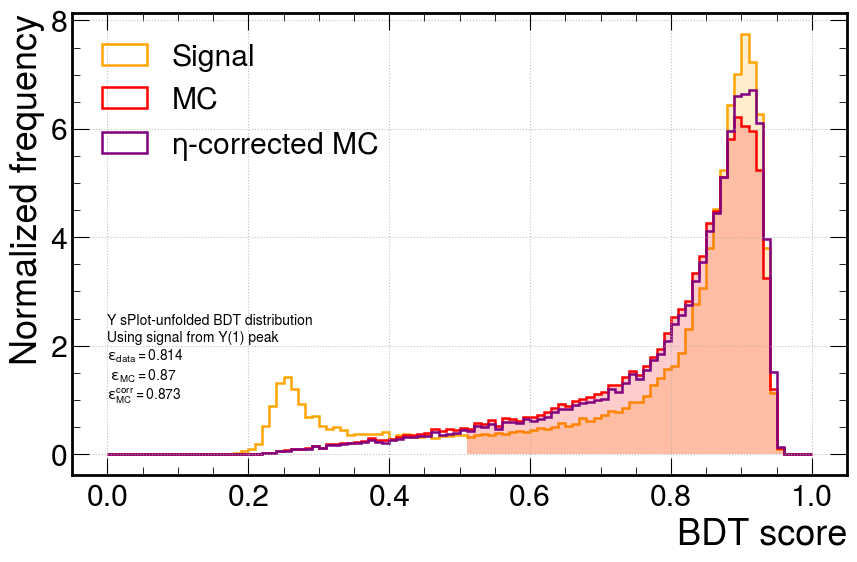

In [ ]:
x = 0.5*(xe[:-1]+xe[1:])
# fine_x = np.linspace(x[0],x[-1],1000)
dx = np.diff(xe)[0]

bin_cut = np.digitize(cutYDataBdt, xe)

hep.style.use("CMS")
fig, ax = plt.subplots(figsize=(10,6))
# ax.hist(scoreYData,nbins,(0,1),True,fYData["bkgYield_sw"], label="Background", color = "blue", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreY1Data,nbins,(0,1),False,fY1Data["sigYield_sw"]/dataTotalYield*nbins, label="Signal", color = "orange", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreY1Data,nbins,(0,1),False,fY1Data["sigYield_sw"]*(scoreY1Data>xe[bin_cut])/dataTotalYield*nbins, color = "orange", zorder=0, histtype='bar', alpha = 0.2)

ax.hist(scoreYMC,nbins,(0,1),False,(fYMC["sigYield_sw"] )/(MCTotalYield/nbins) , label="MC", color = "red", zorder=0, histtype='step', linewidth = 1.8)
ax.hist(scoreYMC,nbins,(0,1),False,fYMC["sigYield_sw"]*(scoreYMC>xe[bin_cut])/MCTotalYield*nbins,  color = "red", zorder=0, histtype='bar', linewidth = 1.8,alpha=0.2)

ax.hist(scoreYMC,nbins,(0,1),False, nbins*((fYMC["sigYield_sw"] )/(MCTotalYield) + corrections) / 2 , label="$\eta$-corrected MC", color = "purple", zorder=0, histtype='step', linewidth = 1.8)
# ax.hist(scoreYMC,nbins,(0,1),False,nbins*(fYMC["sigYield_sw"]/MCTotalYield + corrections)/2*(scoreYMC>xe[bin_cut]),  color = "purple", zorder=0, histtype='bar', linewidth = 1.8,alpha=0.2)

ax.text(0.,1, f"Y sPlot-unfolded BDT distribution \nUsing signal from Y(1) peak\n$\epsilon_{{data}} = ${round(effData,3)} \n $\epsilon_{{MC}} = ${round(effMC,3)}\n$\epsilon_{{MC}}^{{corr}} = ${round(effMC_corr,3)}", fontsize = 10)

ax.grid()
ax.legend()    
ax.set_xlabel("BDT score")
ax.set_ylabel("Normalized frequency")

# print(xe[histYB<0],histYB[histYB<0])


In [ ]:
print(np.sum(corrections))

1.00000000000034


In this section will plot the fits 

In [ ]:
def parse_text_file(filename):
    # Initialize an empty dictionary to store the results
    result_dict = {}
    
    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
            
            name = ""
            i=0

            for line in lines:
                i+=1
                # Remove leading and trailing whitespace
                line = line.strip()
                
                # Check if the line is not empty and starts with a double-quote
                if line and line.startswith('"'):
                    # Split the line by double-quotes
                    name = line.split('"')[1]
                    i=0
                
                if (i==2): 
                    val = line.split('"')[0] 
                    # Add the string and number to the dictionary
                    result_dict[name] = float(val)
    
    except FileNotFoundError:
        print(f"The file '{filename}' was not found.")
    
    return result_dict


In [ ]:

def plotPeak(mass,pars,components,range=None,title=None,plot_data=True):
    hep.style.use("CMS")
    cmap = plt.cm.tab10.colors
    fig, ax = plt.subplots(2,1,sharex = True,figsize=(12,9),gridspec_kw={'height_ratios': [2, 1]})

    w, xe = np.histogram(mass, bins=100, range = range)
    x = 0.5*(xe[:-1]+xe[1:])
    fine_x = np.linspace(x[0],x[-1],1000)
    werr = w ** 0.5
    dx = np.diff(xe)[0]

    names = components.keys()
    functions = [components[key] for key in names]

    ax[0].errorbar(x, w, werr, xerr=dx, fmt = 'o' , markersize = 3, capsize = 3, label="$m_{\mu\mu}^{off}$", color = "black", zorder=0)
    for f,name,color in zip(functions,names,cmap[:len(names)]):
        if (name=="Total"): ax[0].plot(fine_x, f(fine_x, *pars)*dx, lw=2, label=name, color = color, zorder=1)
        else: ax[0].plot(fine_x, f(fine_x, *pars)*dx, linestyle = '--', lw=1.5, label=name, color = color)

    ax[1].set_xlabel('Dimuon mass $m_{\mu\mu}$ [GeV]')
    ax[0].set_ylabel('Frequency')
    ax[0].set_xlim(range)
    # ax[0].set_ylim((0,1.2*dx*f(np.mean(globals()[peak+"_lims"]), *args)))
    ax[1].set_ylim(-1,1)
    ax[0].legend(title=title,fontsize=14,title_fontsize=16)
    ax[0].grid(True)

    # ax[1].errorbar(x, w/dx/pdf(x, *pars)[1], fmt = 's' ,  markersize = 4,capsize = 2, color = "blue")
    ax[1].errorbar(x, np.divide(ak.to_numpy(w)-dx*components["Total"](x, *pars), ak.to_numpy(w), out=np.zeros((nbins,)), where=ak.to_numpy(w) != 0), fmt = '.' , label =r"$\frac{data - fit}{data}$", markersize = 8,capsize = 2, color = "blue")
    ax[1].axhline(y=0, color='black', linestyle='--')
    ax[1].legend(loc="lower left", fontsize = 14,title_fontsize = 14)
    plt.subplots_adjust(hspace=0.)


jpsi_lims = 2.6,3.56
jpsi_args = ["bkgYield", "bkgDecayConst", "sigYield", "mu", "sigmaL", "alphaL", "nL", "sigmaR", "alphaR", "nR", "GaussFraction", "sigma"]
def jpsi_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  (bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
            )
def jpsi_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
def jpsi_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst)


Y_lims = 8.5,11.2
Y_MC_args = ["bkgYield", "bkgDecayConst", "sigYield", "mu", "sigmaL", "alphaL", "nL", "sigmaR", "alphaR", "nR", "GaussFraction", "sigma"]
def Y_MC_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  (bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
            )
def Y_MC_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
def Y_MC_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst)


Y_args = ["bkgYield", "bkgDecayConst", "sigYield", "alpha",  "sigmaL", "sigmaR", "mu1","mu2","mu3", "sigma1","sigma2","sigma3", "n1","n2", "n3", "GaussFraction", "fracY2", "fracY3"]
def Y_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  (bkgYield*truncexpon.pdf(x,Y_lims[0],Y_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*(
                            (1-fracY2-fracY3)*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n1, sigmaL,alpha, n1,sigmaR,mu1) + 
                            GaussFraction*norm.pdf(x,mu1, sigma1)) +
                            fracY2*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n2, sigmaL,alpha, n2,sigmaR,mu2) + 
                            GaussFraction*norm.pdf(x,mu2, sigma2)) +
                            fracY3*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n3, sigmaL,alpha, n3,sigmaR,mu3) + 
                            GaussFraction*norm.pdf(x,mu3, sigma3)))
                    )
def Y_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  (sigYield*(
                            (1-fracY2-fracY3)*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n1, sigmaL,alpha, n1,sigmaR,mu1) + 
                            GaussFraction*norm.pdf(x,mu1, sigma1)) +
                            fracY2*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n2, sigmaL,alpha, n2,sigmaR,mu2) + 
                            GaussFraction*norm.pdf(x,mu2, sigma2)) +
                            fracY3*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n3, sigmaL,alpha, n3,sigmaR,mu3) + 
                            GaussFraction*norm.pdf(x,mu3, sigma3)))
                    )
def Y_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  bkgYield*truncexpon.pdf(x,Y_lims[0],Y_lims[1],0,-1/bkgDecayConst)
                    

ModuleNotFoundError: No module named 'numba_stats'

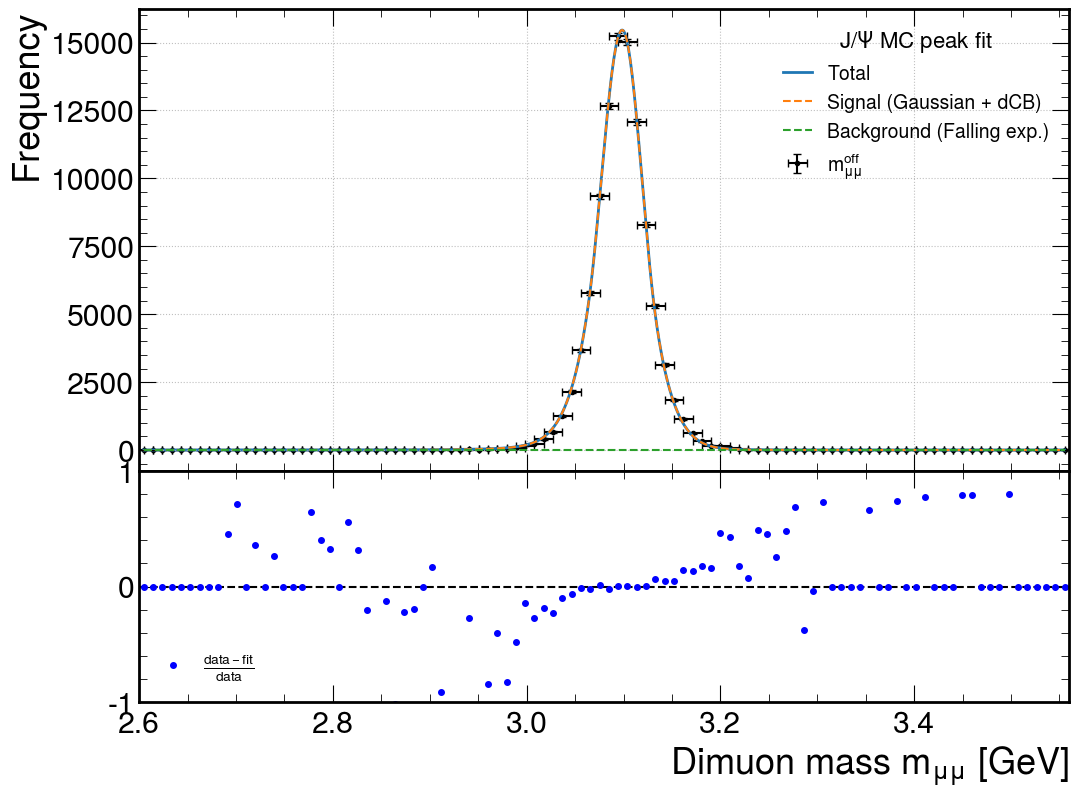

In [ ]:
filename = "SPlotJpsi_fit_MC_lxy.dot"
jpsi_MC_pars = parse_text_file(filename)
components = {"Total":jpsi_dCB_pdf, "Signal (Gaussian + dCB)":jpsi_dCB_pdf_sig, "Background (Falling exp.)":jpsi_dCB_pdf_bkg }
plotPeak(fJpsiMC["Mm_mass"],[jpsi_MC_pars[key] for key in jpsi_args],components, range = jpsi_lims, title="$J/\Psi$ MC peak fit")

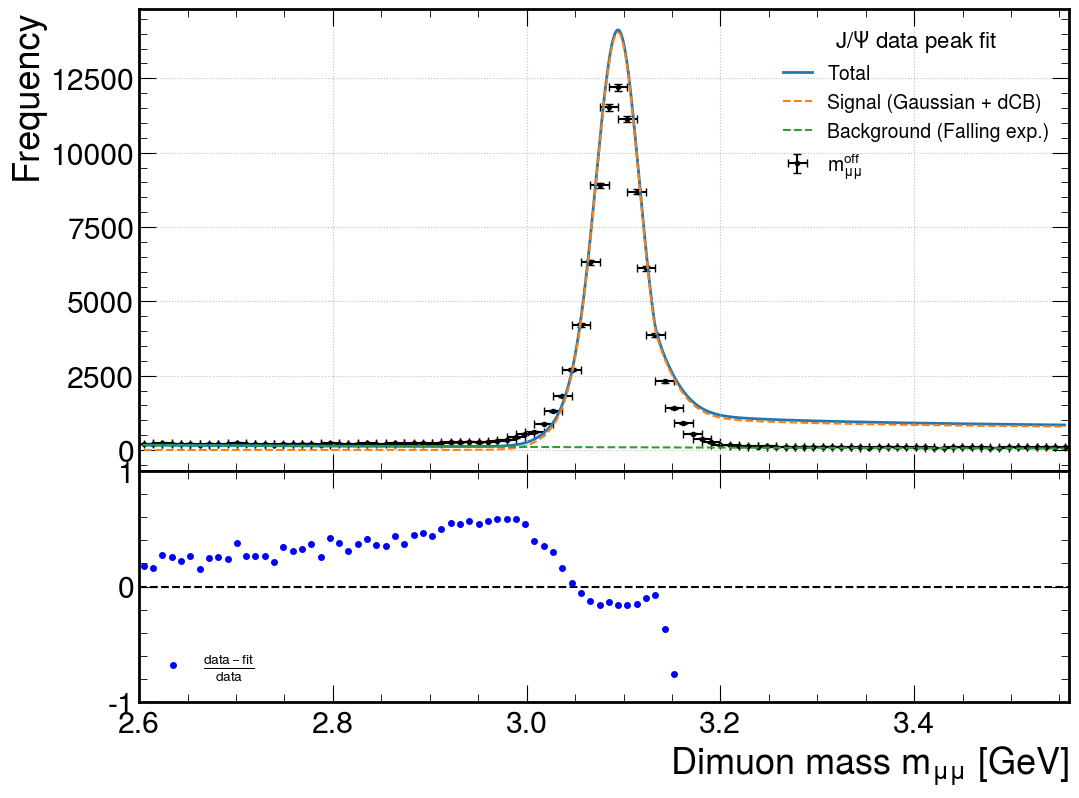

In [ ]:
filename = "SPlotJpsi_fit_data_lxy.dot"
jpsi_data_pars = parse_text_file(filename)
components = {"Total":jpsi_dCB_pdf, "Signal (Gaussian + dCB)":jpsi_dCB_pdf_sig, "Background (Falling exp.)":jpsi_dCB_pdf_bkg }
plotPeak(fJpsiData["Mm_mass"],[jpsi_data_pars[key] for key in jpsi_args],components, range = jpsi_lims, title="$J/\Psi$ data peak fit")

[9.39, 9.3, 9.46, 9.34, 9.53, 9.63, ..., 9.28, 9.25, 9.43, 9.45, 9.56, 9.54]


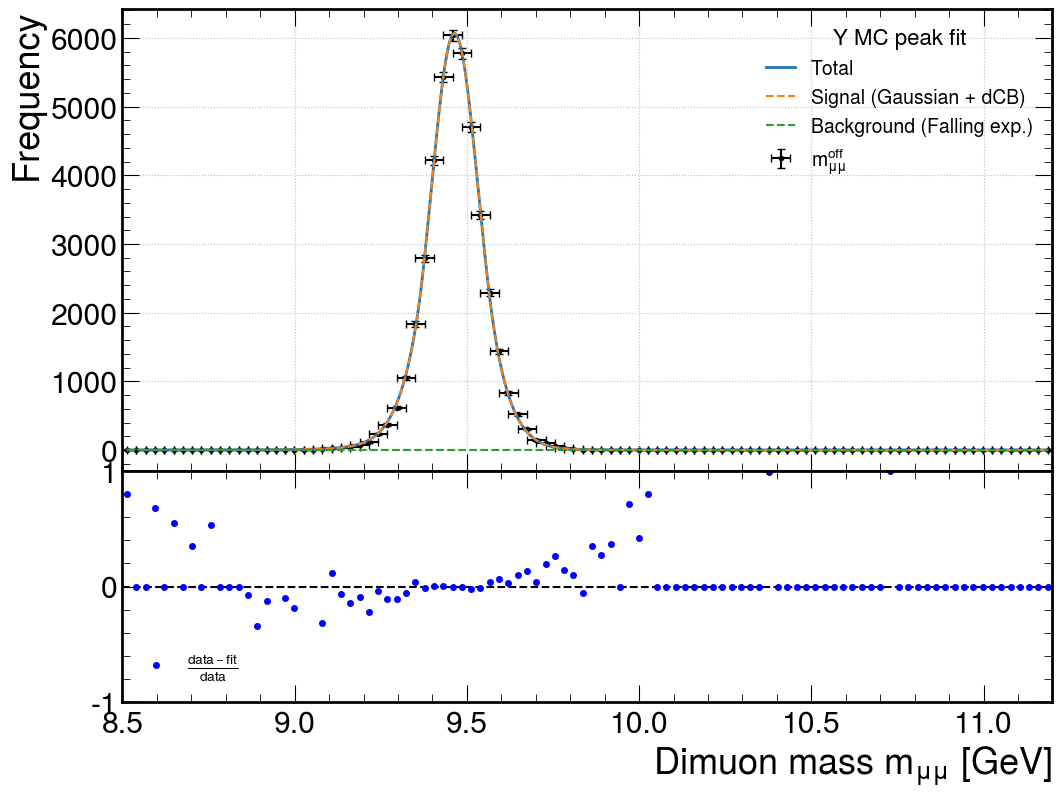

In [ ]:
filename = "SPlotY_fit_MC_lxy.dot"
Y_MC_pars = parse_text_file(filename)
components = {"Total":Y_MC_dCB_pdf, "Signal (Gaussian + dCB)":Y_MC_dCB_pdf_sig, "Background (Falling exp.)":Y_MC_dCB_pdf_bkg }
plotPeak(fYMC["Mm_mass"],[Y_MC_pars[key] for key in Y_MC_args],components, range = Y_lims, title="Y MC peak fit")
print(fYMC["Mm_mass"])

{'massModel': 0.367982, 'sigModel': 0.07769, 'sig2': 0.208215, 'Gaussian2': 0.026685, 'Mm_mass': 9.85, 'mu2': 10.011795, 'sigma2': 0.0601, 'GaussFraction': 0.149803, 'CB2': 0.240201, 'sigmaL': 0.095796, 'sigmaR': 0.087374, 'alpha': 1.858088, 'n2': 11.191686, 'fracY2': 0.203338, 'sig3': 0.157288, 'Gaussian3': 0.908564, 'mu3': 10.343932, 'sigma3': 1.127883, 'CB3': 0.024915, 'n3': 1.00183, 'fracY3': 0.179818, 'sig1': 0.011459, 'Gaussian1': 0.0, 'mu1': 9.452206, 'sigma1': 0.047717, 'CB1': 0.013479, 'n1': 2.13966, 'sigYield': 52889.861946, 'bkgModel': 0.693888, 'bkgDecayConst': -0.037101, 'bkgYield': 47110.292873}


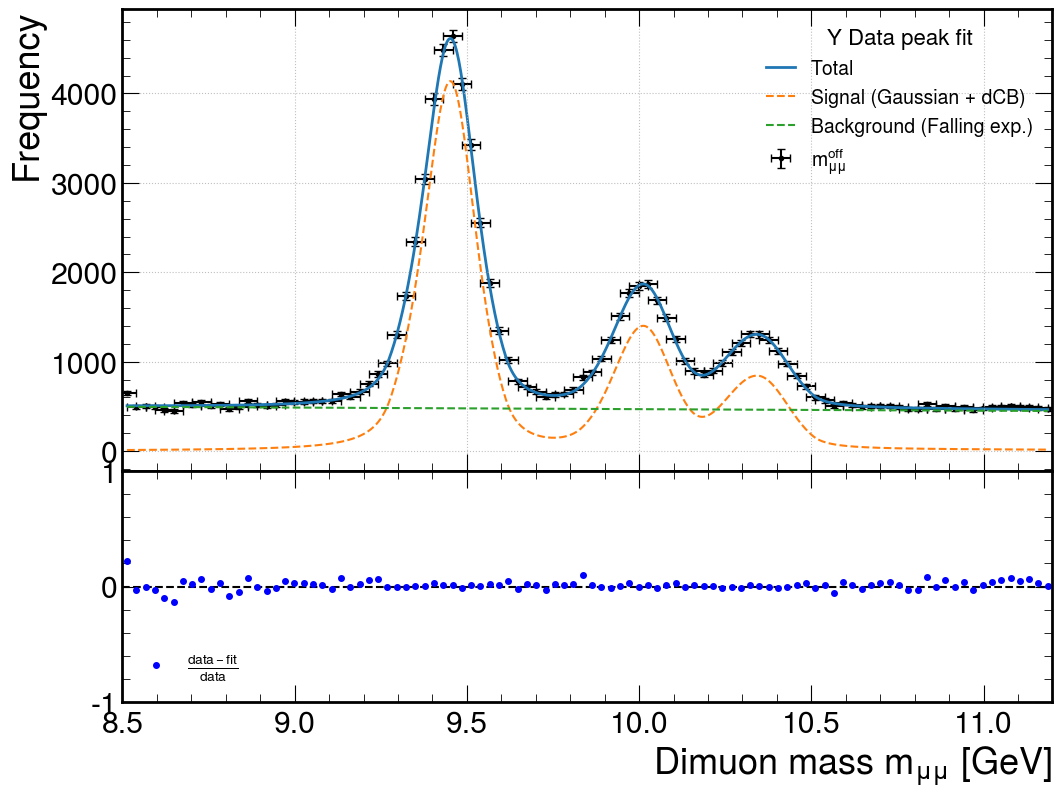

In [ ]:
filename = "SPlotY_fit_data_lxy.dot"
Y_pars = parse_text_file(filename)
print(Y_pars)



Y_pars["n3"]=1.5




components = {"Total":Y_dCB_pdf, "Signal (Gaussian + dCB)":Y_dCB_pdf_sig, "Background (Falling exp.)":Y_dCB_pdf_bkg }
plotPeak(fYData["Mm_mass"],[Y_pars[key] for key in Y_args],components, range = Y_lims, title="Y Data peak fit")

In [ ]:

jpsi_args = {"bkgYield":{"in":1e3, "range": (0,1e6)}, 
             "bkgDecayConst":{"in":-0.8, "range": (-1,-0.1)},
             "sigYield":{"in":8e3, "range": (0,1e6)}, 
             "mu":{"in":3.094, "range": (3,3.2)}, 
             "sigmaL":{"in":0.02, "range": (0,.1)}, 
             "alphaL":{"in":3, "range": (0,5)}, 
             "nL":{"in":1, "range": (0,10)}, 
             "sigmaR":{"in":0.02, "range": (0,.1)}, 
             "alphaR":{"in":1.8, "range": (0,5)}, 
             "nR":{"in":1, "range": (0,10)}, 
             "GaussFraction":{"in":0.6, "range": (0,1)}, 
             "sigma":{"in":0.02, "range": (0,0.1)}}

# cf_Phi = ExtendedUnbinnedNLL(ak.to_numpy(fJpsiData["Mm_mass"][:10000]),jpsi_dCB_pdf)
# iv = [jpsi_args[key]["in"] for key in jpsi_args.keys()]
# mJpsi = Minuit(cf_Phi,*iv)
# mJpsi.limits = [jpsi_args[key]["range"] for key in jpsi_args.keys()]


# mJpsi.fixed["bkgDecayConst"] = True
# mJpsi.fixed["sigma"] = True

# mJpsi.fixed["nR"] = True
# mJpsi.fixed["sigmaL"] = True
# mJpsi.fixed["alphaL"] = True
# mJpsi.fixed["nL"] = True
# mJpsi.fixed["sigmaR"] = True

# mJpsi.migrad()#ncall=100000 , iterat/e = 10)
# mJpsi.hesse()   
# mJpsi.interactive()